In [304]:
import pandas as pd
import numpy as np 
import pandas as pd 
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import os

## ML model to predict subscribers’ churn


In [314]:
df = pd.read_csv('DataForModeling_2.csv')
df.head()

,account_id,plan,currency,cohort_start_date,number_of_payments,gender,genre1,genre2,type,games,age,hours,is_churner,one_two_payments
0,564213846,SMALL,USD,2019-04-01 00:00:00+02,2,male,action,simulation,mobile,7,21,12.517218,1,1
1,255842811,SMALL,EUR,2019-11-01 00:00:00+01,5,male,simulation,sports,computer,7,24,1.466285,1,0
2,50117180,SMALL,EUR,2019-11-01 00:00:00+01,12,female,adventure,strategy,computer,8,33,9.266135,0,0
3,629564594,LARGE,EUR,2020-11-01 00:00:00+01,1,female,adventure,action,mobile,9,26,12.491518,1,1
4,945851052,SMALL,USD,2019-06-01 00:00:00+02,19,female,action,action,computer,5,29,7.874287,0,0


In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_id          2000 non-null   int64  
 1   plan                2000 non-null   object 
 2   currency            2000 non-null   object 
 3   cohort_start_date   2000 non-null   object 
 4   number_of_payments  2000 non-null   int64  
 5   gender              2000 non-null   object 
 6   genre1              2000 non-null   object 
 7   genre2              2000 non-null   object 
 8   type                2000 non-null   object 
 9   games               2000 non-null   int64  
 10  age                 2000 non-null   int64  
 11  hours               2000 non-null   float64
 12  is_churner          2000 non-null   int64  
 13  one_two_payments    2000 non-null   int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 218.9+ KB


In [316]:
# making a copy for future predictions
df_prediction = df.copy()

In [317]:
# Assumption 1: all payments that exist per account are sequentilal, i.e. no account_id was paused and resumed payments
# Assumption 2: user activity is a summary of game playing for thee first 3 months of subscription
# NOTE: Only user who made more than 2 payments will be considered for the modeling

In [318]:
df['account_id'].value_counts().sum()

2000

In [319]:
# filtering out users who made 2 payments or less
df = df[(df['number_of_payments'] > 2)].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_id          1302 non-null   int64  
 1   plan                1302 non-null   object 
 2   currency            1302 non-null   object 
 3   cohort_start_date   1302 non-null   object 
 4   number_of_payments  1302 non-null   int64  
 5   gender              1302 non-null   object 
 6   genre1              1302 non-null   object 
 7   genre2              1302 non-null   object 
 8   type                1302 non-null   object 
 9   games               1302 non-null   int64  
 10  age                 1302 non-null   int64  
 11  hours               1302 non-null   float64
 12  is_churner          1302 non-null   int64  
 13  one_two_payments    1302 non-null   int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 142.5+ KB


In [320]:
# filtering out users with unknown is_churn status
# df = df[(df['is_churner'] != 2)]

# columns_to_drop = ['account_id', 'number_of_payments', 'cohort_start_date', 'one_two_payments', 'gender', 'currency']
columns_to_drop = ['number_of_payments', 'cohort_start_date', 'one_two_payments']

df.drop(columns=columns_to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)

# variable info after recoding and non-relevant variables drop for is_churner 0/1

df_eda = df[(df['is_churner'] != 2)]
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191 entries, 0 to 1301
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   account_id  1191 non-null   int64  
 1   plan        1191 non-null   object 
 2   currency    1191 non-null   object 
 3   gender      1191 non-null   object 
 4   genre1      1191 non-null   object 
 5   genre2      1191 non-null   object 
 6   type        1191 non-null   object 
 7   games       1191 non-null   int64  
 8   age         1191 non-null   int64  
 9   hours       1191 non-null   float64
 10  is_churner  1191 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 111.7+ KB


In [321]:
df_eda['is_churner'].value_counts()

is_churner
0    843
1    348
Name: count, dtype: int64

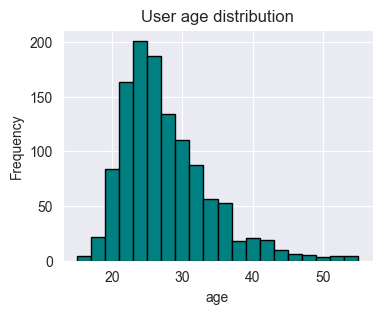

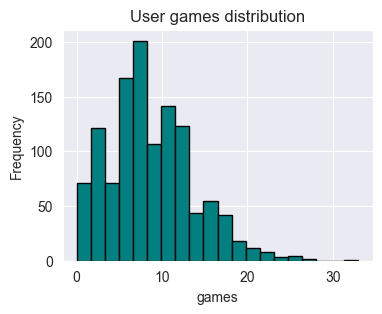

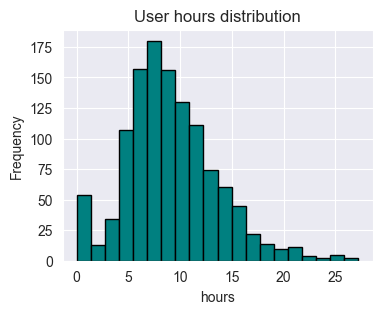

In [322]:
num_columns = ['age', 'games', 'hours']

for col in num_columns:
    plt.figure(figsize=(4, 3))
    plt.hist(df_eda[col], bins=20, color='teal', edgecolor='black')
    #sns.histplot(data=df[num_columns], bins=20, kde=True, multiple="stack", palette="muted")
    #plt.hist(df[df['is_churner'] == 1][col], bins=20, color='orange', edgecolor='black', alpha=0.7, label='Churners')
    sns.set_style("darkgrid")
    plt.title(f'User {col} distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

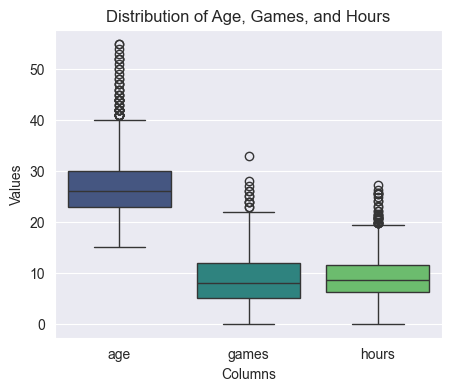

In [323]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=df_eda[num_columns], palette='viridis')
plt.title('Distribution of Age, Games, and Hours')
plt.xlabel('Columns')
plt.ylabel('Values')
plt.show()

plan
SMALL     990
MEDIUM    143
LARGE      58
Name: count, dtype: int64


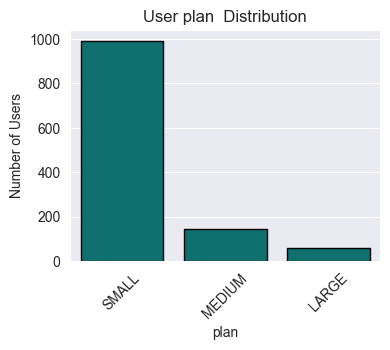

currency
EUR    635
USD    556
Name: count, dtype: int64


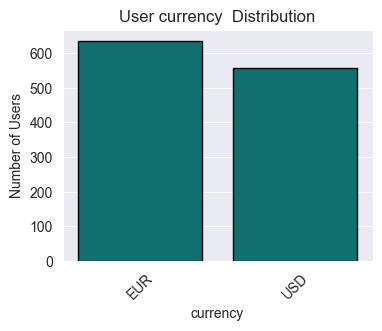

gender
male      830
female    361
Name: count, dtype: int64


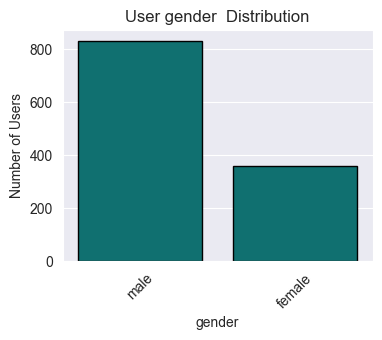

type
computer    738
mobile      379
tablet       74
Name: count, dtype: int64


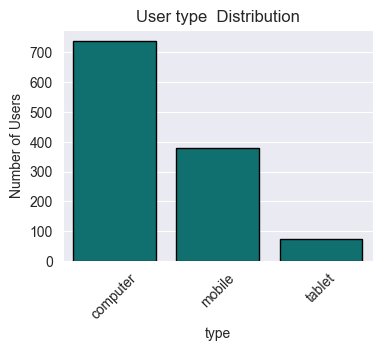

genre1
action          342
adventure       265
role-playing    214
sports          157
strategy        109
simulation      104
Name: count, dtype: int64


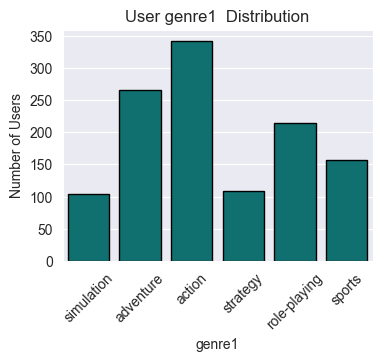

genre2
adventure       336
action          264
role-playing    196
sports          162
strategy        157
simulation       76
Name: count, dtype: int64


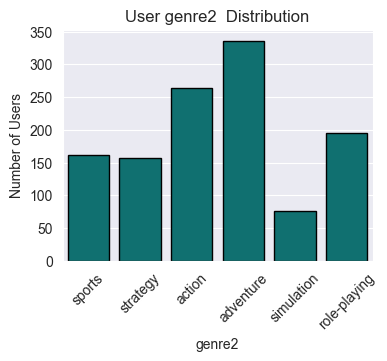

In [324]:
cat_columns = ['plan', 'currency', 'gender', 'type', 'genre1', 'genre2']

for col in cat_columns:

    # calculate category count for each variable
    vc = df_eda[col].value_counts()
    print(vc)

    # plot category count for each variable
    plt.figure(figsize=(4, 3))
    sns.countplot(x=df_eda[col], color='teal', edgecolor='black')
    plt.title(f'User {col}  Distribution')
    plt.xlabel(col)
    plt.ylabel('Number of Users')
    plt.xticks(rotation=45)
    plt.show()

In [325]:
df_eda['is_churner'].value_counts()

is_churner
0    843
1    348
Name: count, dtype: int64

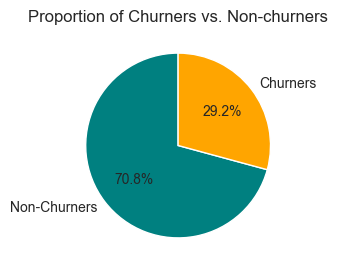

In [326]:
# Category count in the target variable distribution: 'is_churner' 
churn_counts = df_eda['is_churner'].value_counts()

# Pie chart of the category proportion
plt.figure(figsize=(3, 3))

plt.pie(churn_counts, labels=['Non-Churners', 'Churners'], autopct='%1.1f%%', startangle=90, \
        colors=['teal', 'orange'])

plt.title('Proportion of Churners vs. Non-churners')
#plt.savefig('proportion_churners.png', bbox_inches='tight')

plt.show()


## Preparing data for the modeling

### Encoding

In [327]:
# Applying binary encoding to gender, currency
df['is_female'] = df['gender'].map({'male': 0, 'female': 1}).astype(bool)
df['is_eur'] = df['currency'].map({'USD': 0, 'EUR': 1}).astype(bool)

# Ensuring binary encoding for the target variable: is_churner

#df['is_churner'] = df['is_churner'].astype(bool) 

# dropping the original columns that were recoded
columns_to_drop = ['gender', 'currency']
df.drop(columns=columns_to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)

In [328]:
# Applying one-hot encoding to categorical variables with more than 2 categories 
columns_to_encode = ['plan', 'genre1', 'genre2', 'type']
df = pd.get_dummies(df, columns=columns_to_encode)

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   account_id           1302 non-null   int64  
 1   games                1302 non-null   int64  
 2   age                  1302 non-null   int64  
 3   hours                1302 non-null   float64
 4   is_churner           1302 non-null   int64  
 5   is_female            1302 non-null   bool   
 6   is_eur               1302 non-null   bool   
 7   plan_LARGE           1302 non-null   bool   
 8   plan_MEDIUM          1302 non-null   bool   
 9   plan_SMALL           1302 non-null   bool   
 10  genre1_action        1302 non-null   bool   
 11  genre1_adventure     1302 non-null   bool   
 12  genre1_role-playing  1302 non-null   bool   
 13  genre1_simulation    1302 non-null   bool   
 14  genre1_sports        1302 non-null   bool   
 15  genre1_strategy      1302 non-null   b

In [330]:
df.head()

,account_id,games,age,hours,is_churner,is_female,is_eur,plan_LARGE,plan_MEDIUM,plan_SMALL,...,genre1_strategy,genre2_action,genre2_adventure,genre2_role-playing,genre2_simulation,genre2_sports,genre2_strategy,type_computer,type_mobile,type_tablet
0,255842811,7,24,1.466285,1,False,True,False,False,True,...,False,False,False,False,False,True,False,True,False,False
1,50117180,8,33,9.266135,0,True,True,False,False,True,...,False,False,False,False,False,False,True,True,False,False
2,945851052,5,29,7.874287,0,True,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False
3,414068704,20,38,7.023802,0,True,False,False,False,True,...,True,False,False,False,False,True,False,True,False,False
4,252693469,9,27,7.638967,1,True,False,False,False,True,...,False,False,False,False,False,True,False,True,False,False


### Independent and target variables for the model

In [331]:
df_model = df[(df['is_churner'] != 2)]

In [332]:
# Step 1: Train-Test Split

# Separate features and target variable
# dropping account_id - not needed for the model

X = df_model.drop(['is_churner', 'account_id'], axis=1)
y = df_model['is_churner']  

In [333]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [334]:
# Step 2: Logistic Regression
logreg_model_v1 = LogisticRegression(max_iter=3000)
#  cross-validation
cv_scores = cross_val_score(logreg_model_v1, X_train, y_train, cv=5)  
logreg_model_v1.fit(X_train, y_train)
logreg_predictions = logreg_model_v1.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} (mean) +/- {cv_scores.std():.2f} (std)')
print(f'Logistic Regression Accuracy: {logreg_accuracy:.2f}')

Cross-Validation Accuracy: 0.74 (mean) +/- 0.02 (std)
Logistic Regression Accuracy: 0.80


In [335]:
# Get the predictors and their coefficients
coef_df = pd.DataFrame({
    'Predictor': X_train.columns,
    'Coefficient': logreg_model_v1.coef_[0]
})

# Sort to identify the most important ones
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("Top Predictors and their Coefficients:")
print(sorted_coef_df[['Predictor', 'Coefficient']].head(5))

Top Predictors and their Coefficients:
           Predictor  Coefficient
4             is_eur     0.872875
5         plan_LARGE     0.866098
7         plan_SMALL    -0.820469
18     genre2_sports     0.469113
15  genre2_adventure    -0.376978


In [336]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
conf_matrix = confusion_matrix(y_test, logreg_predictions)
tn, fp, fn, tp = conf_matrix.ravel()
# Sensitivity (Recall)
sensitivity = recall_score(y_test, logreg_predictions)
# Specificity
specificity = tn / (tn + fp)
# Positive Predictive Value (Precision)
ppv = precision_score(y_test, logreg_predictions)
# Negative Predictive Value
npv = tn / (tn + fn)
# Accuracy
accuracy = accuracy_score(y_test, logreg_predictions)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Positive Predictive Value (Precision): {ppv:.2f}')
print(f'Negative Predictive Value: {npv:.2f}')
print(conf_matrix)
classification_rep = classification_report(y_test, logreg_predictions)


Logistic Regression Accuracy: 0.80
Sensitivity (Recall): 0.42
Specificity: 0.94
Positive Predictive Value (Precision): 0.73
Negative Predictive Value: 0.82
[[165  10]
 [ 37  27]]


In [337]:
df_copy = df.copy()

In [338]:
# Step 4: Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy:.2f}')

Random Forest Classifier Accuracy: 0.79


Random Forest Classifier Accuracy: 0.79
Sensitivity (Recall): 0.39
Specificity: 0.94
Positive Predictive Value (Precision): 0.69
Negative Predictive Value: 0.81
[[164  11]
 [ 39  25]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87       175
           1       0.69      0.39      0.50        64

    accuracy                           0.79       239
   macro avg       0.75      0.66      0.68       239
weighted avg       0.78      0.79      0.77       239

     Feature  Importance
2      hours    0.235784
1        age    0.184053
0      games    0.171209
4     is_eur    0.043686
3  is_female    0.028686


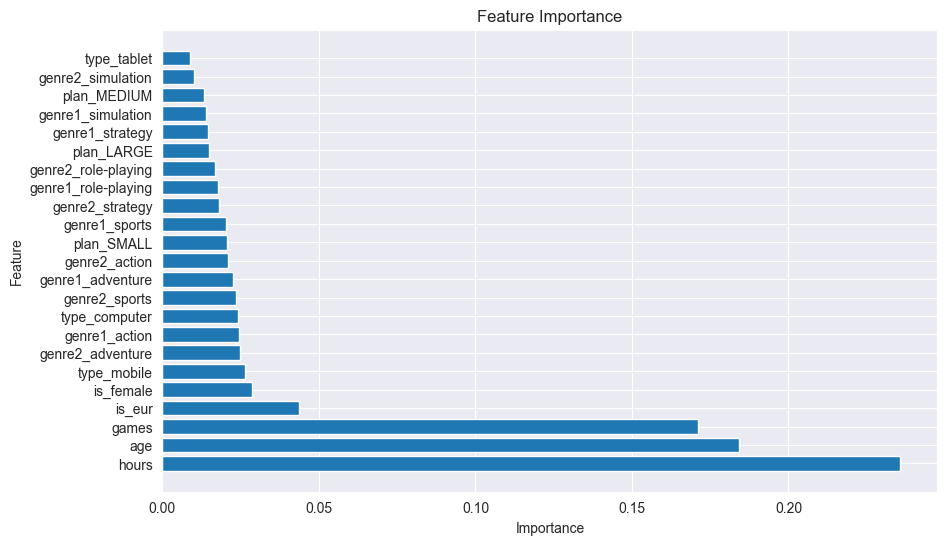

In [339]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
conf_matrix = confusion_matrix(y_test, rf_predictions)
tn, fp, fn, tp = conf_matrix.ravel()
# Sensitivity (Recall)
sensitivity = recall_score(y_test, rf_predictions)
# Specificity
specificity = tn / (tn + fp)
# Positive Predictive Value (Precision)
ppv = precision_score(y_test, rf_predictions)
# Negative Predictive Value
npv = tn / (tn + fn)
# Accuracy
accuracy = accuracy_score(y_test, rf_predictions)

print(f'Random Forest Classifier Accuracy: {accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Positive Predictive Value (Precision): {ppv:.2f}')
print(f'Negative Predictive Value: {npv:.2f}')
print(conf_matrix)

classification_rep = classification_report(y_test, rf_predictions)
print("\nClassification Report:\n", classification_rep)

# Get feature importances
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features and their importances
print(feature_importance_df.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## Additional Pre-processing to Improve the Model 

### 1. Identifying outliers

In [340]:
df_model = df[(df['is_churner'] != 2)]

# Count outliers and remove them if justified

for col in num_columns:
    # Calculating IQR
    Q1 = df_model[col].quantile(0.25)
    Q3 = df_model[col].quantile(0.75)
    IQR = Q3 - Q1

    # Identifing outliers
    outliers = ((df_model[col] < (Q1 - 1.5 * IQR)) | (df_model[col] > (Q3 + 1.5 * IQR)))
    num_outliers = outliers.sum()
    print(f'Number of outliers in {col}: {num_outliers}')
    # Removing outliers
    df_model = df_model[~outliers]

df_model = df_model.reset_index(drop=True)


Number of outliers in age: 51
Number of outliers in games: 11
Number of outliers in hours: 27


### 2. Re-scaling continuous variables

#### 2.1. Creating a scaler instance

In [341]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# columns to rescale
columns_to_rescale = ['age', 'hours', 'games']

# Fit the scaler on the training data and transform both training and test data
X_train[columns_to_rescale] = scaler.fit_transform(X_train[columns_to_rescale])
X_test[columns_to_rescale] = scaler.transform(X_test[columns_to_rescale])

#### 2.2. Re-running models after re-scaling 

In [342]:
# re-running Logistic Regression
logreg_model = LogisticRegression(max_iter=3000)
logreg_model.fit(X_train, y_train)
logreg_predictions = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print(f'Logistic Regression Accuracy (re-ran after re-scaling): {logreg_accuracy:.2f}')

Logistic Regression Accuracy (re-ran after re-scaling): 0.79


In [343]:
# re-running random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Random Forest Classifier Accuracy  (re-ran after re-scaling): {rf_accuracy:.2f}')

Random Forest Classifier Accuracy  (re-ran after re-scaling): 0.81


#### 3. Creating interaction terms

In [344]:
# Create interaction terms 

df_model['Age_Hours_Interaction'] = df_model['age'] * df_model['hours']
df_model['Games_Hours_Interaction'] = df_model['games'] * df_model['hours']
df_model['Age_Games_Interaction'] = df_model['age'] * df_model['games']

# Separate features and target variable
X = df_model.drop(['is_churner', 'account_id'], axis=1)
y = df_model['is_churner']  

# dropping the original columns that were recoded
columns_to_drop = ['age', 'hours', 'games']
X.drop(columns=columns_to_drop, inplace=True)
X.reset_index(drop=True, inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### 3.1. Re-running models with the interaction terms

In [345]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   account_id           1302 non-null   int64  
 1   games                1302 non-null   int64  
 2   age                  1302 non-null   int64  
 3   hours                1302 non-null   float64
 4   is_churner           1302 non-null   int64  
 5   is_female            1302 non-null   bool   
 6   is_eur               1302 non-null   bool   
 7   plan_LARGE           1302 non-null   bool   
 8   plan_MEDIUM          1302 non-null   bool   
 9   plan_SMALL           1302 non-null   bool   
 10  genre1_action        1302 non-null   bool   
 11  genre1_adventure     1302 non-null   bool   
 12  genre1_role-playing  1302 non-null   bool   
 13  genre1_simulation    1302 non-null   bool   
 14  genre1_sports        1302 non-null   bool   
 15  genre1_strategy      1302 non-null   b

In [346]:
# Re-runnin Logistic Regression
logreg_model = LogisticRegression(max_iter=3000)
logreg_model.fit(X_train, y_train)
logreg_predictions = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
print(f'Logistic Regression Accuracy: {logreg_accuracy:.2f}')

# re-evaluate the performance of the Logistic Regression model

conf_matrix = confusion_matrix(y_test, logreg_predictions)
classification_rep = classification_report(y_test, logreg_predictions)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)


Logistic Regression Accuracy: 0.74

Confusion Matrix:
 [[134  12]
 [ 45  30]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.82       146
           1       0.71      0.40      0.51        75

    accuracy                           0.74       221
   macro avg       0.73      0.66      0.67       221
weighted avg       0.74      0.74      0.72       221



In [347]:
# Re-running Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy:.2f}')

# Re-evaluate the performance of the random Forest Classifier model

conf_matrix = confusion_matrix(y_test, rf_predictions)
classification_rep = classification_report(y_test, rf_predictions)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Random Forest Classifier Accuracy: 0.71

Confusion Matrix:
 [[137   9]
 [ 54  21]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.94      0.81       146
           1       0.70      0.28      0.40        75

    accuracy                           0.71       221
   macro avg       0.71      0.61      0.61       221
weighted avg       0.71      0.71      0.67       221



## 4. Hyperparameter Tuning

### 4.1. Logistic Regression

In [348]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 881 entries, 726 to 860
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   is_female                881 non-null    bool   
 1   is_eur                   881 non-null    bool   
 2   plan_LARGE               881 non-null    bool   
 3   plan_MEDIUM              881 non-null    bool   
 4   plan_SMALL               881 non-null    bool   
 5   genre1_action            881 non-null    bool   
 6   genre1_adventure         881 non-null    bool   
 7   genre1_role-playing      881 non-null    bool   
 8   genre1_simulation        881 non-null    bool   
 9   genre1_sports            881 non-null    bool   
 10  genre1_strategy          881 non-null    bool   
 11  genre2_action            881 non-null    bool   
 12  genre2_adventure         881 non-null    bool   
 13  genre2_role-playing      881 non-null    bool   
 14  genre2_simulation        881 

In [349]:
from sklearn.model_selection import GridSearchCV

# hyperparameters to tune
param_grid = {
    'penalty': ['l2'],  # lbfgs solver only supports 'l2' penalty
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

# Creating GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Finding the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Using best hyperparameters to create the final model

final_logreg_model = LogisticRegression(
    max_iter=3000,
    penalty=best_params['penalty'],
    C=best_params['C']
)

# fitting the best parameter model on the entire training set
final_logreg_model.fit(X_train, y_train)

# predictions on the test set
final_logreg_predictions = final_logreg_model.predict(X_test)

# Re-evaluating the performance of the final Logistic Regression model
final_logreg_accuracy = accuracy_score(y_test, final_logreg_predictions)
final_conf_matrix = confusion_matrix(y_test, final_logreg_predictions)
final_classification_rep = classification_report(y_test, final_logreg_predictions)

# Step 11: Print the final results
print(f'Final Logistic Regression Accuracy: {final_logreg_accuracy:.2f}')
print("\nFinal Confusion Matrix:\n", final_conf_matrix)
print("\nFinal Classification Report:\n", final_classification_rep)


Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Final Logistic Regression Accuracy: 0.74

Final Confusion Matrix:
 [[134  12]
 [ 45  30]]

Final Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.82       146
           1       0.71      0.40      0.51        75

    accuracy                           0.74       221
   macro avg       0.73      0.66      0.67       221
weighted avg       0.74      0.74      0.72       221



### 4.2. Random Forest 

In [350]:
# Define Random Forest model
rf_model = RandomForestClassifier()

#  hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')

# Perform grid search on the training data
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
print(f'Best Hyperparameters for Random Forest: {best_params_rf}')

# Use the best model to make predictions on the test set
rf_predictions_tuned = grid_search_rf.predict(X_test)

# Evaluate the performance of the Random Forest model with tuned hyperparameters
rf_accuracy_tuned = accuracy_score(y_test, rf_predictions_tuned)
conf_matrix_rf_tuned = confusion_matrix(y_test, rf_predictions_tuned)
classification_rep_rf_tuned = classification_report(y_test, rf_predictions_tuned)

print(f'Random Forest Classifier Accuracy with Tuned Hyperparameters: {rf_accuracy_tuned:.2f}')
print("\nConfusion Matrix:\n", conf_matrix_rf_tuned)
print("\nClassification Report:\n", classification_rep_rf_tuned)


Best Hyperparameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classifier Accuracy with Tuned Hyperparameters: 0.71

Confusion Matrix:
 [[135  11]
 [ 53  22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.92      0.81       146
           1       0.67      0.29      0.41        75

    accuracy                           0.71       221
   macro avg       0.69      0.61      0.61       221
weighted avg       0.70      0.71      0.67       221



# Who will churn?


Use the model created in exercise 2, to predict the users that will become churners.
Use the users from whom you know the data needed as input for the model (at least 3
months order payments), but we do not know if they will become churners or not

In [351]:
df_predictions = df_copy[(df_copy['is_churner'] == 2)]
X_new = df_predictions.drop(['is_churner', 'account_id'], axis=1)
predictions = logreg_model_v1.predict(X_new)
predictions_df = df_predictions.copy()
predictions_df['is_churner_predict'] = predictions
predictions_df[['account_id', 'is_churner_predict']]

,account_id,is_churner_predict
46,528797743,0
73,295039119,0
85,325893747,0
92,557591166,0
94,523024296,0
...,...,...
1263,782793965,1
1276,101326362,1
1287,619588831,0
1291,494273232,0


In [352]:
predictions_df['is_churner_predict'].value_counts()

is_churner_predict
0    107
1      4
Name: count, dtype: int64

In [ ]:
predictions_df = predictions_df[['account_id', 'is_churner_predict']]
predictions_df.head()

In [353]:
# Saving a file with a list of account_ids and predicted churn status

predictions_df.to_csv('predicted_churners.csv', index=False)

In [354]:
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: C:\Users\LLANA\Desktop\CodeOpAssignments\qustodio tech test
